# TensorNetworks in Neural Networks.

Here, we have a small toy example of how to use a TN inside of a fully connected neural network.

First off, let's install tensornetwork

In [3]:
!pip install tensornetwork

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.enable_v2_behavior
# Import tensornetwork
import tensornetwork as tn
# Set the backend to tesorflow
# (default is numpy)
tn.set_default_backend("tensorflow")

# TensorNetwork layer definition

Here, we define the TensorNetwork layer we wish to use to replace the fully connected layer. Here, we simply use a 2 node Matrix Product Operator network to replace the normal dense weight matrix.

We TensorNetwork's NCon API to keep the code short.

In [4]:

class TNLayer(tf.keras.layers.Layer):

  def __init__(self):
    super(TNLayer, self).__init__()
    # Create the variables for the layer.
    self.a_var = tf.Variable(tf.random.normal(
            shape=(32, 32, 2), stddev=1.0/32.0),
             name="a", trainable=True)
    self.b_var = tf.Variable(tf.random.normal(shape=(32, 32, 2), stddev=1.0/32.0),
                             name="b", trainable=True)
    self.bias = tf.Variable(tf.zeros(shape=(32, 32)), name="bias", trainable=True)

  def call(self, inputs):
    # Define the contraction.
    # We break it out so we can parallelize a batch using
    # tf.vectorized_map (see below).
    def f(input_vec, a_var, b_var, bias_var):
      # Reshape to a matrix instead of a vector.
      input_vec = tf.reshape(input_vec, (32,32))

      # Now we create the network.
      a = tn.Node(a_var)
      b = tn.Node(b_var)
      x_node = tn.Node(input_vec)
      a[1] ^ x_node[0]
      b[1] ^ x_node[1]
      a[2] ^ b[2]

      # The TN should now look like this
      #   |     |
      #   a --- b
      #    \   /
      #      x

      # Now we begin the contraction.
      c = a @ x_node
      result = (c @ b).tensor

      # To make the code shorter, we also could've used Ncon.
      # The above few lines of code is the same as this:
      # result = tn.ncon([x, a_var, b_var], [[1, 2], [-1, 1, 3], [-2, 2, 3]])

      # Finally, add bias.
      return result + bias_var
  
    # To deal with a batch of items, we can use the tf.vectorized_map
    # function.
    # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
    result = tf.vectorized_map(
        lambda vec: f(vec, self.a_var, self.b_var, self.bias), inputs)
    return tf.nn.relu(tf.reshape(result, (-1, 1024)))

# Smaller model
These two models are effectively the same, but notice how the TN layer has nearly 10x fewer parameters.

In [5]:
Dense = tf.keras.layers.Dense
fc_model = tf.keras.Sequential(
    [
     tf.keras.Input(shape=(2,)),
     Dense(1024, activation=tf.nn.relu),
     Dense(1024, activation=tf.nn.relu),
     Dense(1, activation=None)])
fc_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              3072      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 1,053,697
Trainable params: 1,053,697
Non-trainable params: 0
_________________________________________________________________


In [6]:
tn_model = tf.keras.Sequential(
    [
     tf.keras.Input(shape=(2,)),
     Dense(1024, activation=tf.nn.relu),
     # Here, we replace the dense layer with our MPS.
     TNLayer(),
     Dense(1, activation=None)])
tn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              3072      
_________________________________________________________________
tn_layer (TNLayer)           (None, 1024)              5120      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
Total params: 9,217
Trainable params: 9,217
Non-trainable params: 0
_________________________________________________________________


# Training a model

You can train the TN model just as you would a normal neural network model! Here, we give an example of how to do it in Keras.

In [7]:
X = np.concatenate([np.random.randn(20, 2) + np.array([3, 3]), 
             np.random.randn(20, 2) + np.array([-3, -3]), 
             np.random.randn(20, 2) + np.array([-3, 3]), 
             np.random.randn(20, 2) + np.array([3, -3]),])

Y = np.concatenate([np.ones((40)), -np.ones((40))])

In [8]:
tn_model.compile(optimizer="adam", loss="mean_squared_error")
tn_model.fit(X, Y, epochs=300, verbose=1)

Train on 80 samples
Epoch 1/300


/hpchome/carin/fk43/anaconda3/envs/tfquant/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/hpchome/carin/fk43/anaconda3/envs/tfquant/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


80/80 [==============================] - 2s 31ms/sample - loss: 0.9814
Epoch 2/300
80/80 [==============================] - 0s 109us/sample - loss: 0.9225
Epoch 3/300
80/80 [==============================] - 0s 110us/sample - loss: 0.8710
Epoch 4/300
80/80 [==============================] - 0s 108us/sample - loss: 0.8133
Epoch 5/300
80/80 [==============================] - 0s 318us/sample - loss: 0.7466
Epoch 6/300
80/80 [==============================] - 0s 110us/sample - loss: 0.6651
Epoch 7/300
80/80 [==============================] - 0s 322us/sample - loss: 0.5698
Epoch 8/300
80/80 [==============================] - 0s 109us/sample - loss: 0.4618
Epoch 9/300
80/80 [==============================] - 0s 384us/sample - loss: 0.3462
Epoch 10/300
80/80 [==============================] - 0s 108us/sample - loss: 0.2349
Epoch 11/300
80/80 [==============================] - 0s 384us/sample - loss: 0.1370
Epoch 12/300
80/80 [==============================] - 0s 393us/sample - loss: 0.0836
Ep

80/80 [==============================] - 0s 108us/sample - loss: 4.8200e-04
Epoch 98/300
80/80 [==============================] - 0s 253us/sample - loss: 4.2168e-04
Epoch 99/300
80/80 [==============================] - 0s 221us/sample - loss: 3.9376e-04
Epoch 100/300
80/80 [==============================] - 0s 107us/sample - loss: 3.5862e-04
Epoch 101/300
80/80 [==============================] - 0s 348us/sample - loss: 3.4401e-04
Epoch 102/300
80/80 [==============================] - 0s 107us/sample - loss: 3.0370e-04
Epoch 103/300
80/80 [==============================] - 0s 235us/sample - loss: 3.0864e-04
Epoch 104/300
80/80 [==============================] - 0s 258us/sample - loss: 2.7271e-04
Epoch 105/300
80/80 [==============================] - 0s 278us/sample - loss: 2.4697e-04
Epoch 106/300
80/80 [==============================] - 0s 241us/sample - loss: 2.5670e-04
Epoch 107/300
80/80 [==============================] - 0s 110us/sample - loss: 2.1704e-04
Epoch 108/300
80/80 [=====

80/80 [==============================] - 0s 108us/sample - loss: 1.1461e-05
Epoch 189/300
80/80 [==============================] - 0s 125us/sample - loss: 1.2464e-05
Epoch 190/300
80/80 [==============================] - 0s 126us/sample - loss: 1.3240e-05
Epoch 191/300
80/80 [==============================] - 0s 396us/sample - loss: 1.1666e-05
Epoch 192/300
80/80 [==============================] - 0s 218us/sample - loss: 1.2119e-05
Epoch 193/300
80/80 [==============================] - 0s 124us/sample - loss: 1.2936e-05
Epoch 194/300
80/80 [==============================] - 0s 230us/sample - loss: 1.1712e-05
Epoch 195/300
80/80 [==============================] - 0s 124us/sample - loss: 1.1184e-05
Epoch 196/300
80/80 [==============================] - 0s 343us/sample - loss: 9.9837e-06
Epoch 197/300
80/80 [==============================] - 0s 109us/sample - loss: 9.8246e-06
Epoch 198/300
80/80 [==============================] - 0s 212us/sample - loss: 9.6729e-06
Epoch 199/300
80/80 [===

80/80 [==============================] - 0s 108us/sample - loss: 2.5787e-06
Epoch 280/300
80/80 [==============================] - 0s 415us/sample - loss: 2.9189e-06
Epoch 281/300
80/80 [==============================] - 0s 109us/sample - loss: 2.6960e-06
Epoch 282/300
80/80 [==============================] - 0s 241us/sample - loss: 2.6521e-06
Epoch 283/300
80/80 [==============================] - 0s 107us/sample - loss: 2.6215e-06
Epoch 284/300
80/80 [==============================] - 0s 353us/sample - loss: 2.3405e-06
Epoch 285/300
80/80 [==============================] - 0s 107us/sample - loss: 3.0599e-06
Epoch 286/300
80/80 [==============================] - 0s 108us/sample - loss: 3.0566e-06
Epoch 287/300
80/80 [==============================] - 0s 537us/sample - loss: 2.4016e-06
Epoch 288/300
80/80 [==============================] - 0s 107us/sample - loss: 2.6270e-06
Epoch 289/300
80/80 [==============================] - 0s 396us/sample - loss: 2.5391e-06
Epoch 290/300
80/80 [===

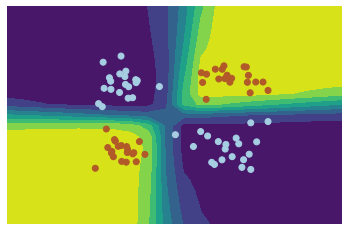

In [9]:
# Plotting code, feel free to ignore.
h = 1.0
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# here "model" is your model's prediction (classification) function
Z = tn_model.predict(np.c_[xx.ravel(), yy.ravel()]) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

# VS Fully Connected

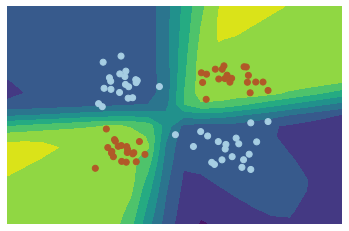

In [10]:
fc_model.compile(optimizer="adam", loss="mean_squared_error")
fc_model.fit(X, Y, epochs=300, verbose=0)
# Plotting code, feel free to ignore.
h = 1.0
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# here "model" is your model's prediction (classification) function
Z = fc_model.predict(np.c_[xx.ravel(), yy.ravel()]) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
